In [1]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

from pclib.nn.models import FCClassifierSS
from pclib.nn.layers import PrecisionWeighted
from pclib.optim.train_selfsup import train
from pclib.utils.plot import plot_stats
from pclib.optim.eval import track_vfe, accuracy
from pclib.utils.functional import vfe, format_y
from pclib.utils.customdataset import PreloadedDataset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:

class TanhTransform(object):
    def __init__(self, a=1., b=0., c=1.0):
        self.a = a
        self.b = b
        self.c = c

    def __call__(self, img):
        return ((img * self.a).tanh() + self.b) * self.c

class InvTanhTransform(object):
    def __call__(self, img):
        num = 1 + img
        div = (1 - img).clamp(min=1e-6)
        m = 0.5 * torch.log(num / div)
        return m

class SigmoidTransform(object):
    def __call__(self, img):
        return img.sigmoid()
    
class ReLUTanhTransform(object):
    def __call__(self, img):
        return F.relu(img.tanh())

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),                                
    transforms.Normalize((0.1307,), (0.3081,)),
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    # InvTanhTransform(),
    transforms.Normalize((0.1307,), (0.3081,)),
    # SigmoidTransform(),
    # TanhTransform(a=2.0),
    # TanhTransform(a=1.0, b=1.0, c=0.5),
])

dataset = datasets.MNIST('../Datasets/', train=True, download=False, transform=transforms.ToTensor())
# # shorten dataset
# length = 1000
# dataset = torch.utils.data.Subset(dataset, range(length))

VAL_RATIO = 0.2
val_len = int(len(dataset) * VAL_RATIO)
train_len = len(dataset) - val_len
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_len, val_len])
train_dataset = PreloadedDataset.from_dataset(train_dataset, train_transform, device)
val_dataset = PreloadedDataset.from_dataset(val_dataset, val_transform, device)
INPUT_SHAPE = 784
NUM_CLASSES = 10

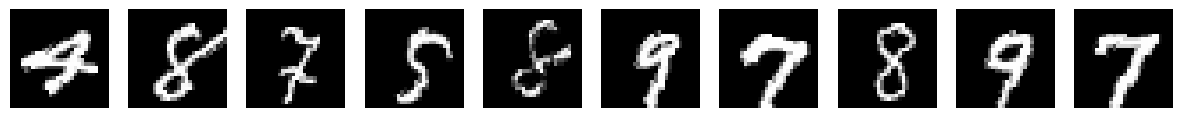

Max value:  tensor(2.8215, device='cuda:0')
Min value:  tensor(-0.4242, device='cuda:0')


In [5]:
# Show some images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

# print max min values
print('Max value: ', train_dataset.transformed_images.max())
print('Min value: ', train_dataset.transformed_images.min())

In [6]:
seed = 42
torch.manual_seed(seed)

model = FCClassifierSS(
    input_size=INPUT_SHAPE, 
    num_classes=NUM_CLASSES, 
    hidden_sizes=[600, 256, 128],
    bias=True, 
    symmetric=True, 
    precision_weighted=False,
    actv_fn=F.relu,
    steps=60,
    gamma=0.1,
    beta=1.0,
    ).to(device)
step = 0
stats = None

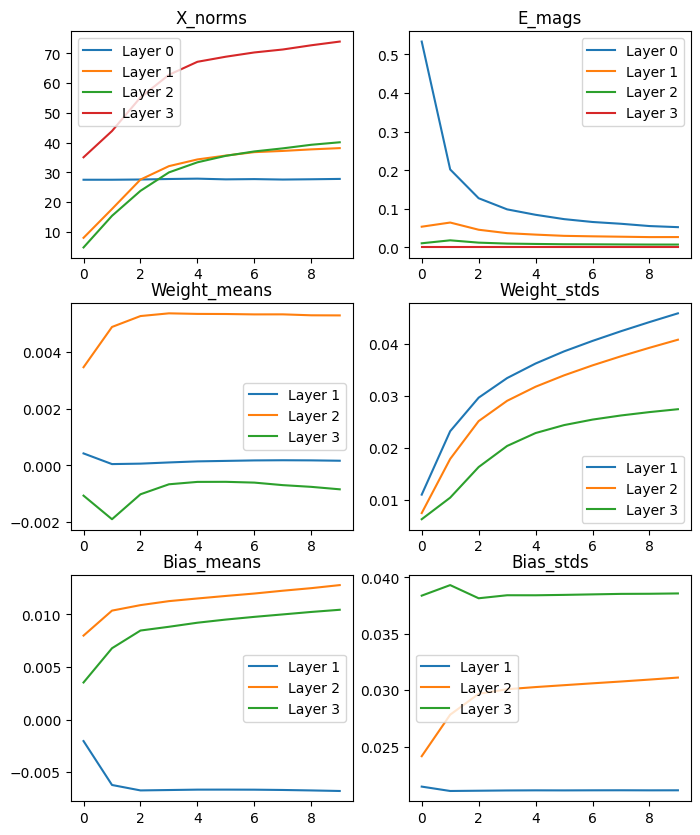

In [7]:
# Train Loop
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
BATCH_SIZE = 1000
REG_COEFF = 0.05

step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    pc_lr=LEARNING_RATE, 
    batch_size=BATCH_SIZE,
    reg_coeff=REG_COEFF,
    step=step, 
    stats=stats,
    device=device,
    pc_optim='AdamW',
    c_optim=None,
)
LEARNING_RATE = 0.0
NUM_EPOCHS = 0
step, stats = train(
    model, 
    train_dataset, 
    val_dataset, 
    NUM_EPOCHS, 
    pc_lr=LEARNING_RATE, 
    c_lr=0.01,
    batch_size=BATCH_SIZE,
    reg_coeff=REG_COEFF,
    step=step, 
    stats=stats,
    device=device,
    pc_optim='AdamW',
    c_optim='AdamW',
)

plot_stats(stats, model)

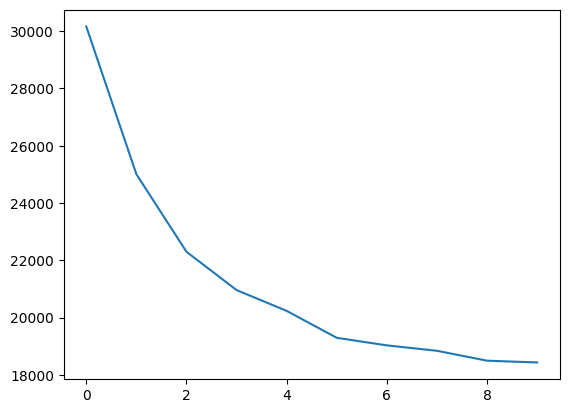

In [8]:
plt.plot(stats['train_corr'])

In [17]:
size = 4
w = torch.randn(size, size)
x = torch.randn(2, size)

y1 = x @ (w * (1.0 - torch.eye(size))) - (x @ (w * torch.eye(size)))

w2 = w * (torch.ones(size) - 2*torch.eye(size))
y2 = x @ w2

torch.allclose(y1, y2)

True

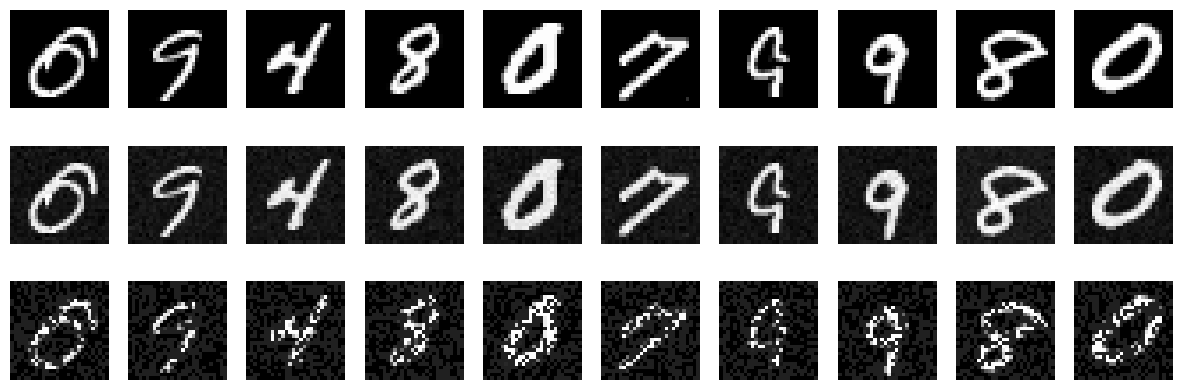

In [7]:
# get 10 images
images = []
noisy_images = []
partial_images = []
labels = []
for i in range(10):
    img, _ = val_dataset[i]
    images.append(img)
    noisy_images.append(img + torch.randn_like(img) * 0.1)
    partial_images.append(img * (torch.rand_like(img) < 0.5))
    labels.append(label)

# show images
fig, axes = plt.subplots(3, 10, figsize=(15, 5))
for i, ax in enumerate(axes[0]):
    ax.imshow(images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    ax.imshow(noisy_images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[2]):
    ax.imshow(partial_images[i].squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()

images = torch.stack(images).flatten(1)
noisy_images = torch.stack(noisy_images).flatten(1)
partial_images = torch.stack(partial_images).flatten(1)

27.750282287597656 19.867991373697915


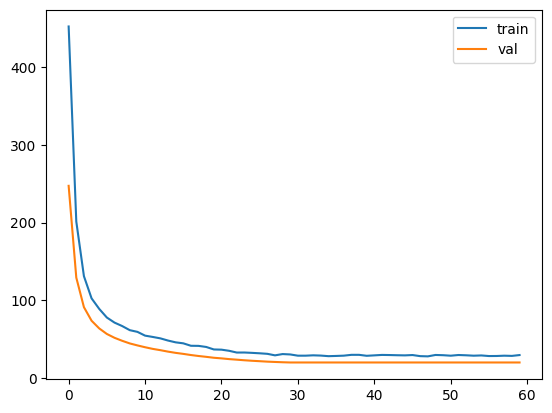

In [23]:
print(min(stats['train_vfe']), min(stats['val_vfe']))
plt.plot(stats['train_vfe'], label='train')
plt.plot(stats['val_vfe'], label='val')
plt.legend()
plt.show()

torch.Size([10, 784])


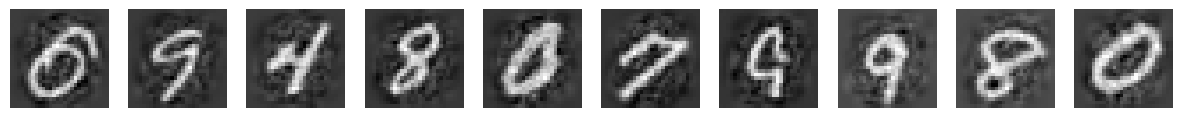

In [9]:
# reconstruct noisy images
out, state = model.reconstruct(noisy_images)
print(out.shape)


# show reconstructed images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(out[i].cpu().reshape(28, 28), cmap='gray')
    ax.axis('off')

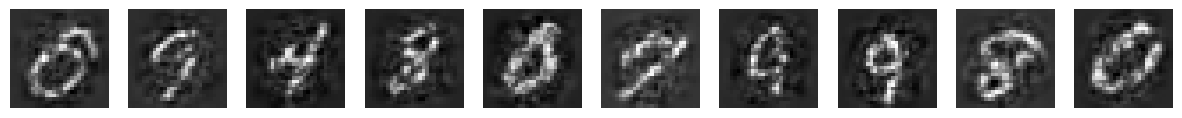

In [10]:
# reconstruct partial images
out, state = model.reconstruct(partial_images)

# show reconstructed images
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow(out[i].cpu().reshape(28, 28), cmap='gray')
    ax.axis('off')

In [15]:
targets = torch.arange(NUM_CLASSES).to(device)
images = model.generate(targets)

fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i, ax in enumerate(axes):
    img = images[i]
    ax.imshow(img.detach().squeeze().cpu().view(28,28), cmap='gray')
    ax.axis('off')

NotImplementedError: 

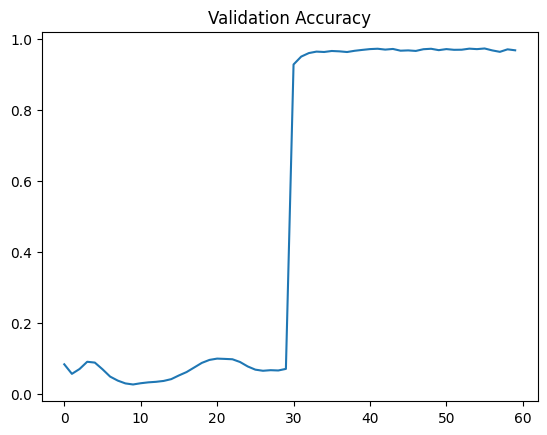

In [17]:
plt.plot(stats['val_acc'])
plt.title("Validation Accuracy")
plt.show()

In [18]:
max(stats['val_acc'])

0.9739166666666667

In [7]:
# Current Accuracy and Error Rate
acc = accuracy(model, val_dataset, steps=0)
error = 100 * (1 - acc)
print(f'Current Val Acc: {acc} | error_rate: {error:0.2f} %')

Current Val Acc: 0.9848333333333333 | error_rate: 1.52 %


In [7]:
# # Shows statistics over multiple models. models = [model1, model2, ...]


# train_vfes = torch.tensor([stats[i]['train_vfe'][-1] for i in range(num_models)])
# val_vfes = torch.tensor([stats[i]['val_vfe'][-1] for i in range(num_models)])
# val_accs = torch.tensor([stats[i]['val_acc'][-1] for i in range(num_models)])

# # Show statistics across models, std is nan if num_models = 1
# print(f"Tra VFE - mean: {train_vfes.mean():.3f} | std: {train_vfes.std():.3f} | min: {train_vfes.min():.3f} | max: {train_vfes.max():.3f}")
# print(f"Val VFE - mean: {val_vfes.mean():.3f} | std: {val_vfes.std():.3f} | min: {val_vfes.min():.3f} | max: {val_vfes.max():.3f}")
# print(f"Val Acc - mean: {val_accs.mean():.3f} | std: {val_accs.std():.3f} | min: {val_accs.min():.3f} | max: {val_accs.max():.3f}")

NameError: name 'num_models' is not defined

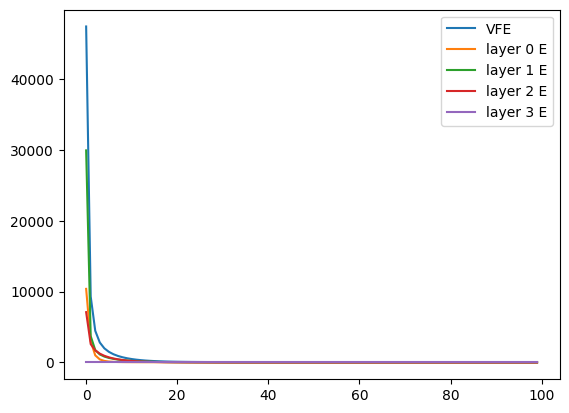

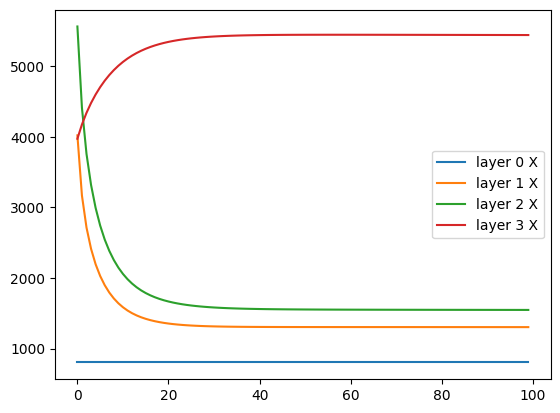

Layer 0 e_min, e_max, x_min, x_max: 803.479, 803.479, 24.984, 10390.275
Layer 1 e_min, e_max, x_min, x_max: 1304.320, 4021.518, 13.409, 29936.723
Layer 2 e_min, e_max, x_min, x_max: 1547.939, 5563.815, 1.147, 7101.028
Layer 3 e_min, e_max, x_min, x_max: 3973.312, 5446.678, 0.000, 0.000


In [9]:
from pclib.utils.functional import format_y
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
images, y = next(iter(train_loader))
x = images.view(images.shape[0], -1)
y = format_y(y, 10)
vfes, X, E = track_vfe(model, x=x, steps=100, plot_Es=True, plot_Xs=True)
for i in range(len(model.layers)):
    print(f'Layer {i} e_min, e_max, x_min, x_max: {min(E[i]):.3f}, {max(E[i]):.3f}, {min(X[i]):.3f}, {max(X[i]):.3f}')

In [12]:
assert isinstance(model.layers[0], PrecisionWeighted), "This cell only works for PrecisionWeighted layers"
# show diag of weight_var matrix as 28x28 image for layer 0
model = model
layer = 0
weight_var = model.layers[0].weight_var.detach().cpu().numpy()
# weight_var = model.layers[-1].weight_var.diag().reshape(28,28).detach().cpu().numpy()
plt.imshow(weight_var, cmap='gray')
plt.colorbar()
plt.show()
weight_var.min(), weight_var.max()


AssertionError: This cell only works for PrecisionWeighted layers